# Unsupervised Learning of Stellar Photometry with Long-Short Term Memory Autoencoders

In this notebook, we demonstrate an application of machine learning in astronomy. We will show how this model can be used for dimensionality reduction and anomaly detection by using a sample of stars with Pan-STARRS photometry.

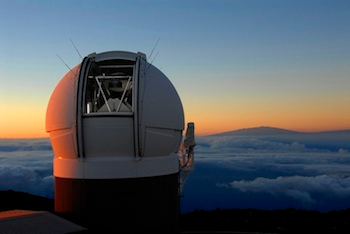

Pan-STARRS is a telescope located near the summit of Haleakala on the island of Maui, Hawaii, and equipped with the world's largest astronomical camera (nearly 1.4 billion pixels!). This survey mapped roughly three-quarters of the night sky in five optical bands (g, r, i, z, y), creating a catalog of over *3 billion* astronomical sources, making it the largest astronomical catalog ever released.


We will walk through:



*   Loading and preparing data
*   Training and validation of the Long-Short Term Memory Autoencoders
*   Exploring the learned latent space
*   Plot an "AI Generated" Hertzsprung-Russell (HR) Diagram
*   Using reconstruction error to detect rare stars.




## Astronomy Crash Cell



*   **Magnitude**: a measure of brightness (lower = brighter).
*   **Photometric Bands (g, r, i, z, y)**: Filters that capture light at different wavelengths.
* **Color**: The difference between magnitudes in two bands (e.g. *g-i*), used to infer temperature or composition.
* **Parallax**: Apparent shift of the position of a star due to the Earth's orbit. Allows us to obtain distance to an object.



## Motivation


A *Spectral Energy Distribution* (SED) is a curve that describes how a star's brightness varies with wavelength, capturing the energy it emits across the electromagnetic spectrum in a low-resolution format.
Below is the spectrum (high-resolution) of our Sun as an example, with the visible wavelengths highlighted.


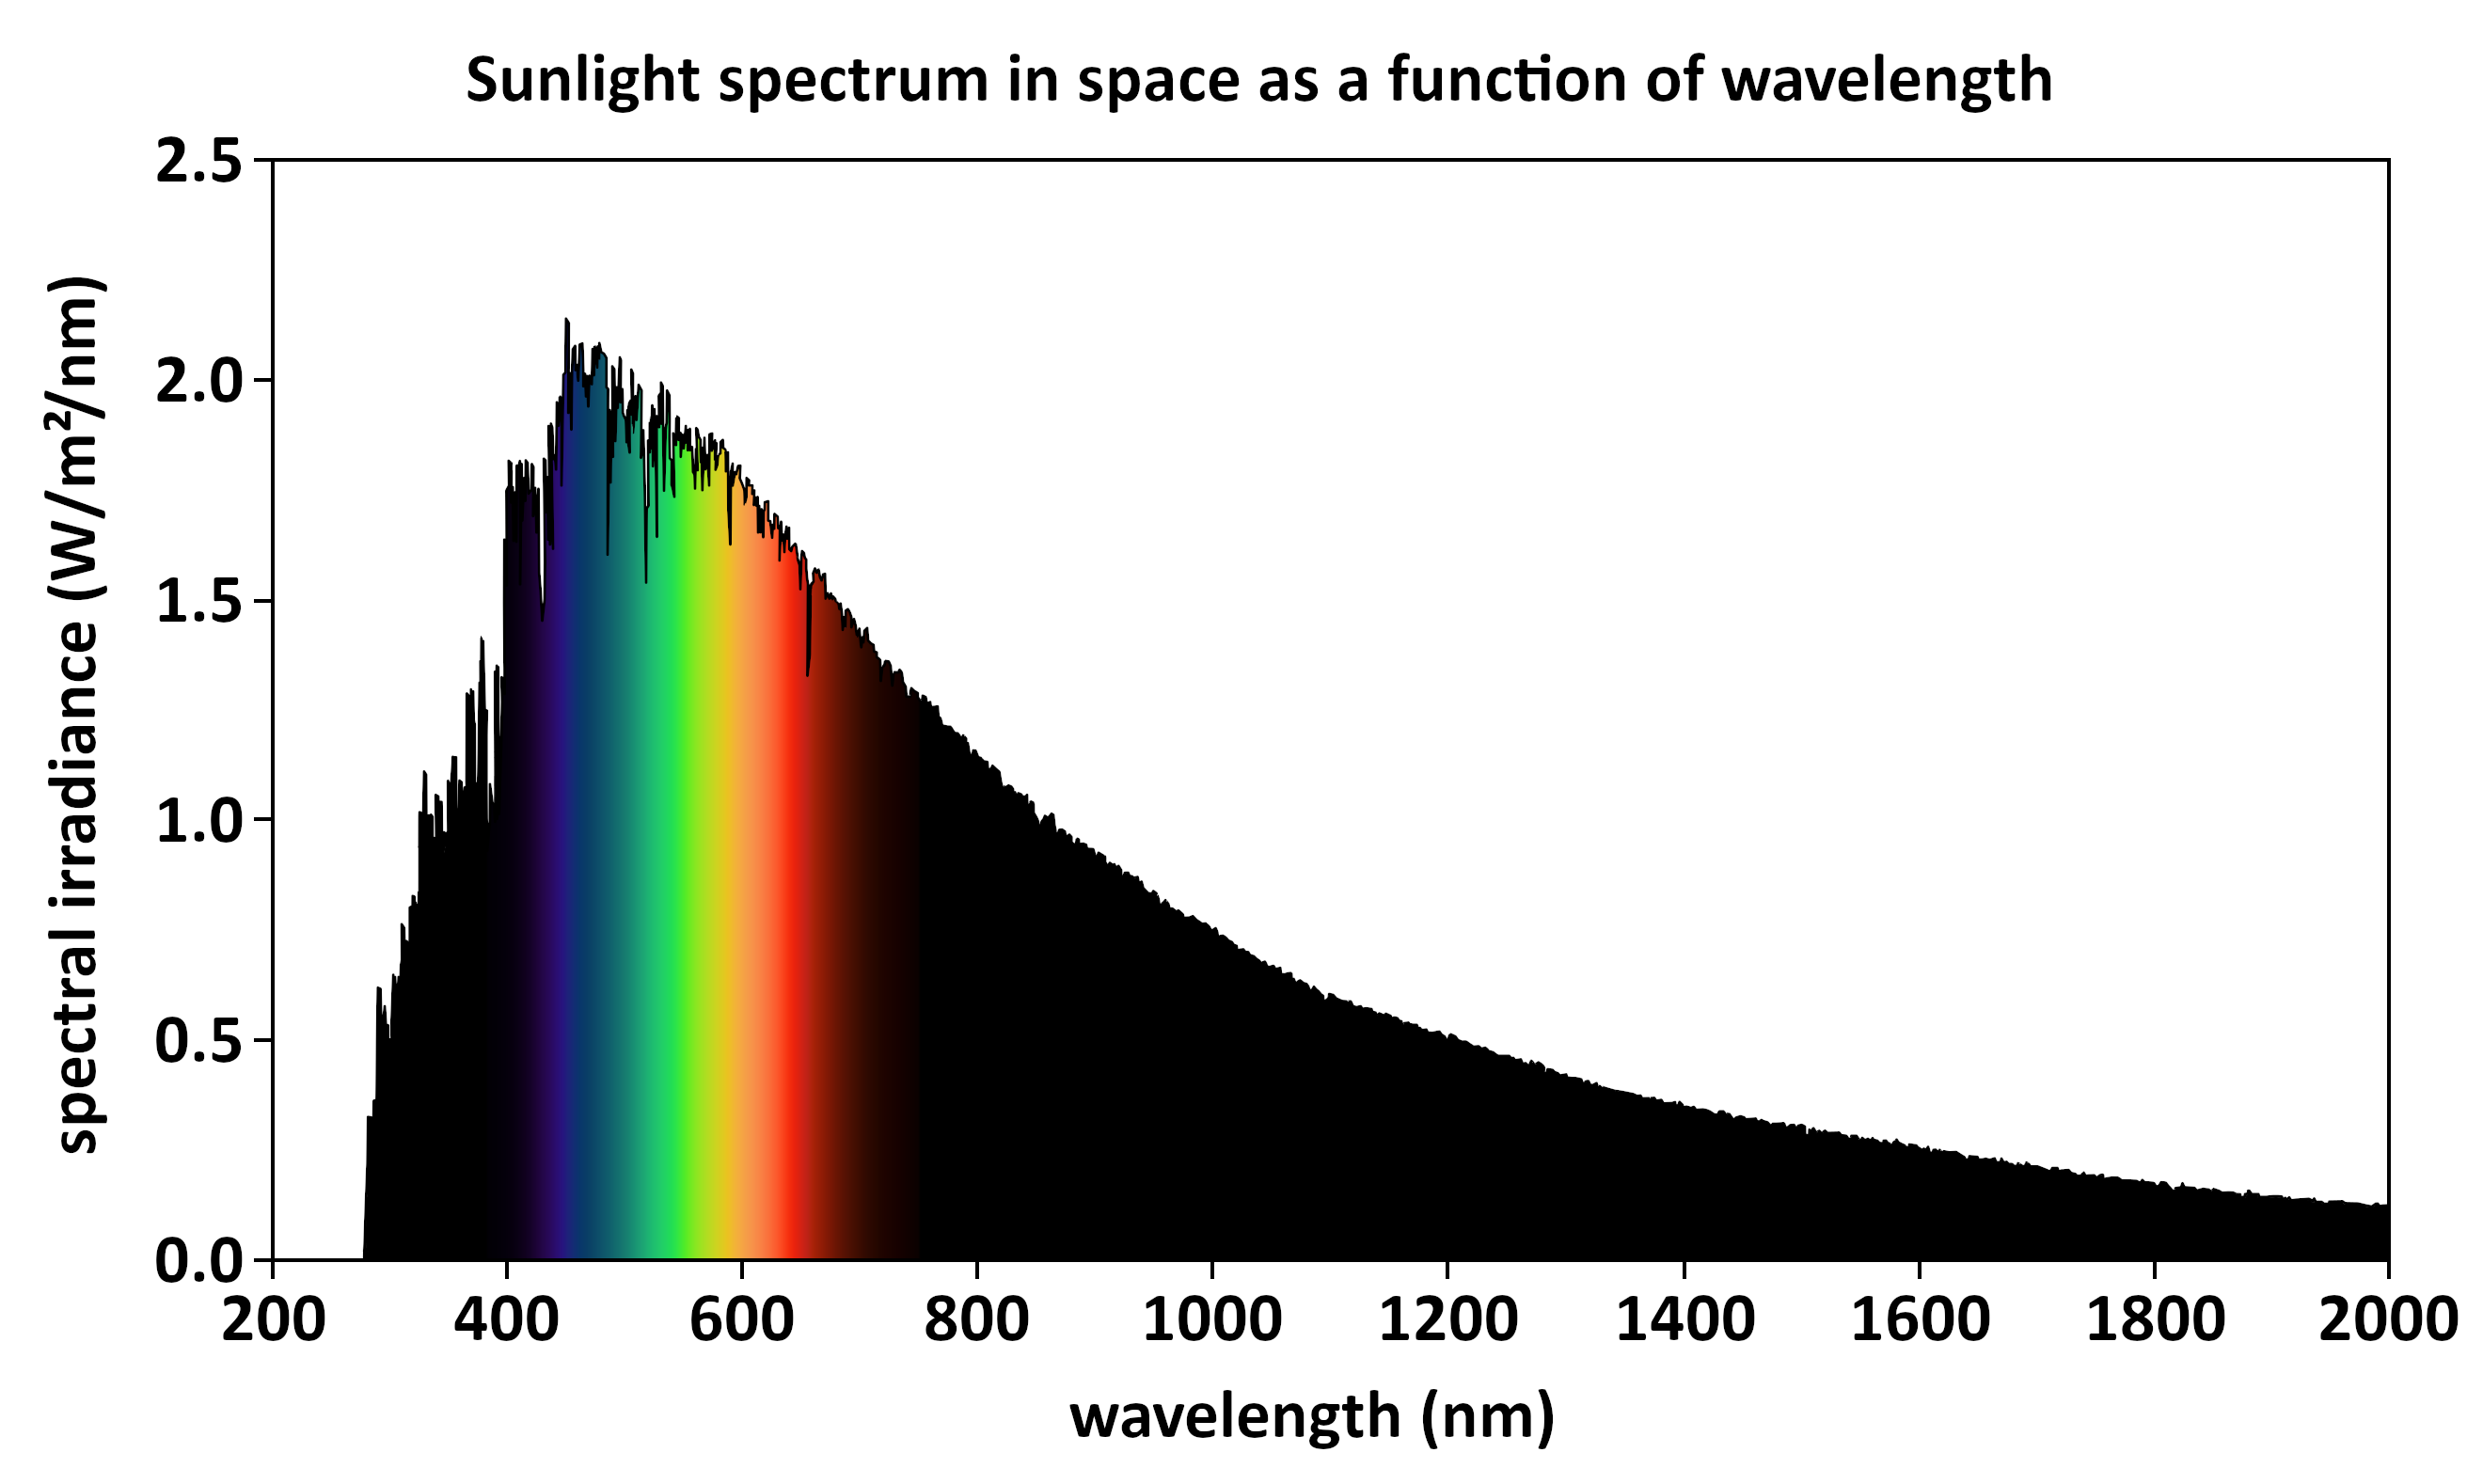


A star's change in brightness over different wavelengths and the steepness of these changes from shorter to longer wavelengths are related to the underlying physical processes and properties of the star such as the surface temperature, metallicity (amount of elements other than hydrogen), and surface gravity.

The figure below showcases the change in brightness for different types of stars (RGB, Horizontal Branch, Blue Straggler, White Dwarf, Brown Dwarf) across different wavelength bands (g, r, i, z, and y).



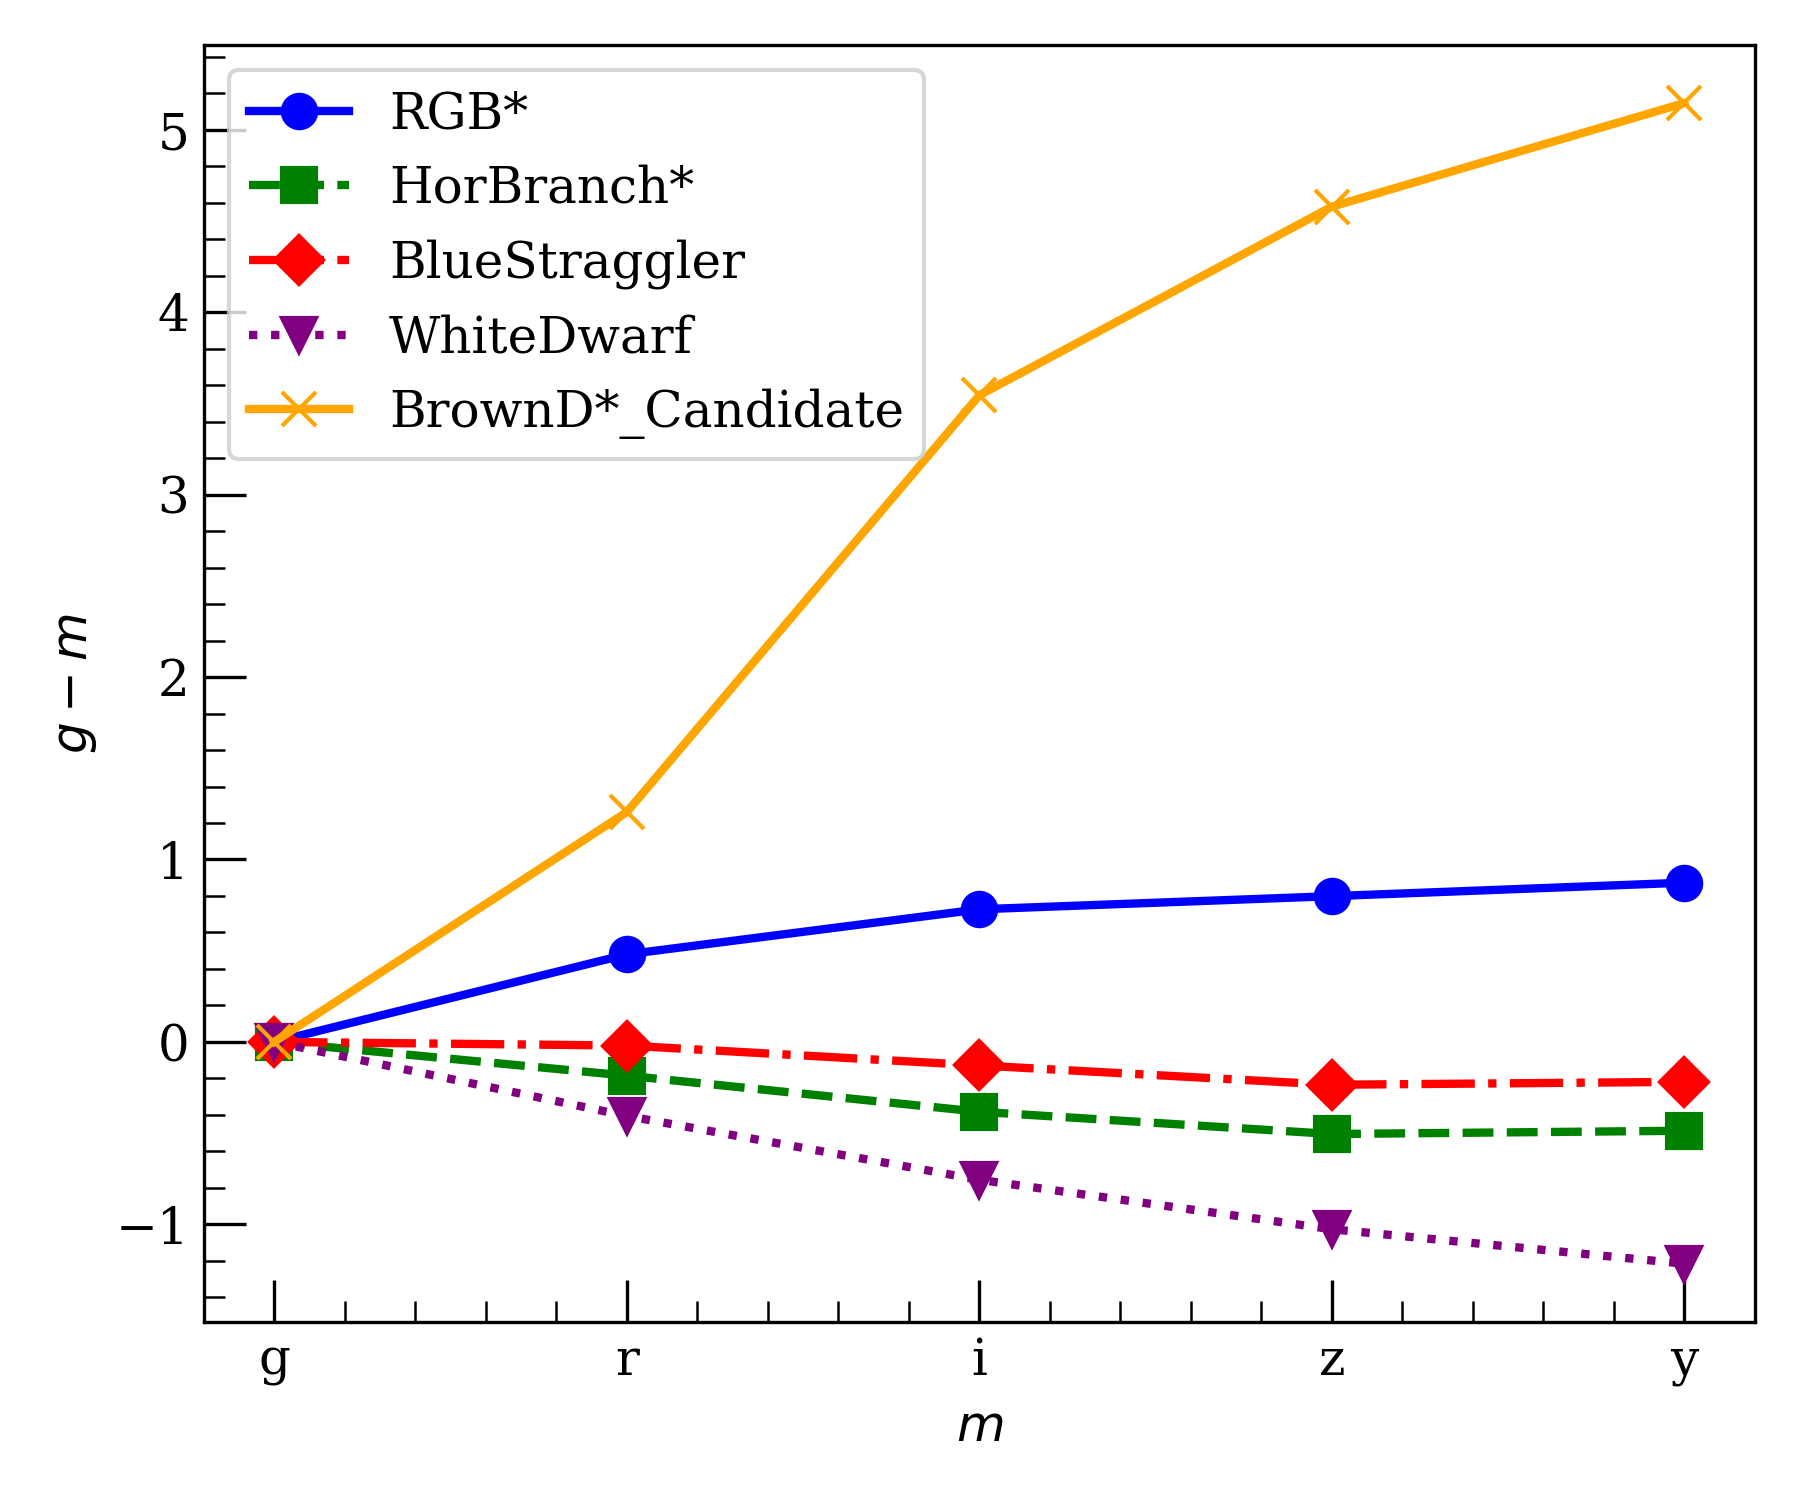

Therefore, one can construct a series of brightness measurements that are sequential in wavelength, which permits the application of machine learning techniques that require sequential (or time-series) data. This is why we will use LSTM units in our model, as they require a sequential input and allow the model to have a form of memory.

Since we do not possess enough labels (classifications for our stars) for our dataset, we must use unsupervised machine learning. Unsupervised machine learning allows the model to freely explore the dataset to discover patterns and structure in data without the need for labeled examples. This is why we will use an autoencoder.

An *autoencoder* is a neural network architecture used in unsupervised learning to efficiently encode data as a method for dimensionality reduction and then to decode it (reconstruct the input from the encoded representation) in order to detect anomalies.

We will combine these and in our case, a *long-short term memory autoencoder* (LSTM-AE) will take the rough shapes of the SEDs and attempt to learn a two-dimensional embedding of the data, called the latent space, and reconstruct the SED shape from the latent space. The model supervises *itself* based on how well it reconstructs the input, bypassing the need for labels.

The goal is for the model to encode patterns present in the stars' SEDs revealed by multiband photometry into a two-dimensional latent space. This latent space can then be used for analysis, distinguishing stellar populations based on physical features. The reconstructed SED shape can be compared to the original, observed SED shape, allowing us to potentially find rare types of stars by looking at poorly reconstructed SEDs.

## Load and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import gdown

import random as rn

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'


First we must install the necessary data. This will include three files. These all contain dereddened Pan-STARRS photometry for stars in a region surrounding the North Galactic Cap. The first is a small subset of the data that has object types in SIMBAD (an astronomical database containing classifications for some of our stars), the second a subset with Gaia parallaxes, and the last the set with no matches. We will see that doing a post-label analysis will greatly enhance our understanding of the latent space.

In [ ]:
# gdown is a package that allows you to download files from a specified Google Drive folder.

# url to the SIMBAD subset
url_ps_simbad ='https://drive.google.com/uc?id=1ocg10VYuknHxZSMXO5Nod3HPYC-ECfRu'

# url to the GAIA subset
url_ps_gaia = 'https://drive.google.com/uc?id=15tDIhrkELUVdnkezq-CPiBP6UsqTVIV5'

# url to the set with no matches.
url_ps_no_match = 'https://drive.google.com/uc?id=1gnuLoIig6e9sjNnP2KVfOaCvmVIq4A2n'

# Download the csv files.
gdown.download(url_ps_simbad, 'ps_simbad.csv', quiet=False)

gdown.download(url_ps_gaia, 'ps_gaia.csv', quiet=False)

gdown.download(url_ps_no_match, 'ps_no_match.csv', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ocg10VYuknHxZSMXO5Nod3HPYC-ECfRu
To: /content/ps_simbad.csv
100%|██████████| 5.74M/5.74M [00:00<00:00, 28.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=15tDIhrkELUVdnkezq-CPiBP6UsqTVIV5
To: /content/ps_gaia.csv
100%|██████████| 63.0M/63.0M [00:00<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gnuLoIig6e9sjNnP2KVfOaCvmVIq4A2n
To: /content/ps_no_match.csv
100%|██████████| 1.16M/1.16M [00:00<00:00, 89.6MB/s]


'ps_no_match.csv'

In [ ]:
# Load csv files into a pandas dataframe.

df_simbad = pd.read_csv('ps_simbad.csv')
df_gaia = pd.read_csv('ps_gaia.csv')
df_no_match = pd.read_csv('ps_no_match.csv')

# Put wanted features in a list. The first list will be used to set the data up
# for input into the model, and the second is used to keep track of the stars ID's and location.

bands = ['g','r','i','z','y']
id_and_location = ['objID', 'ra','dec']

columns_to_keep = id_and_location + bands

# Combine all three dataframes into one.
df_combined = pd.concat([df_simbad[columns_to_keep], df_gaia[columns_to_keep], df_no_match[columns_to_keep]])
print(f'shape: {df_combined.shape}, number of stars: {df_combined.shape[0]}')

# Useful statistics
print(df_combined[bands].describe())


shape: (833160, 8), number of stars: 833160
                   g              r              i              z  \
count  833160.000000  833160.000000  833160.000000  833160.000000   
mean       18.189134      17.267004      16.566872      16.258674   
std         1.983028       1.730854       1.375496       1.236412   
min        13.388000      13.221000      12.964000      12.400000   
25%        16.530000      15.855000      15.499000      15.328000   
50%        18.325000      17.305000      16.631000      16.330000   
75%        19.870000      18.700000      17.676000      17.229000   
max        22.936000      21.939000      20.613000      20.455000   

                   y  
count  833160.000000  
mean       16.095247  
std         1.184212  
min        12.138000  
25%        15.219000  
50%        16.168000  
75%        17.007000  
max        20.356000  


Now we must prepare the data for input in the LSTM-AE.

When working with neural networks, it's important to scale the data, that is to adjust your input values so that they all fall in a small, consistent range. This helps the model learn more efficiently as it avoids having certain features contribute more heavily or weakly to the loss, the thing the network is trying to minimize.

Usually, you scale the data so it has a mean of zero and a variance of one (StandardScaler), or has values only between (0,1) (MinMaxScaler). In those cases, you must **first split** your dataset into your training and validation sets, then **fit the scaler to the training data.** Then you can use the fitted scaler to transform the validation data. This is to avoid **data leakage**, which is when information from the validation set "leaks" into the training process, giving the model an unfair advantage; akin to seeing the answers before a test.


However, in our case, we're not using a learned scaler. Our data already is in a narrow range, so we just need to put it on a smaller scale. We can achieve this simply by dividing all values by 10; a fixed, manual scaling. Since there is no risk of data leakage, we can apply this scaling to the full dataset without splitting first.


Then, we reshape the data into the 3D format expected by LSTM layers: `(samples, timesteps=1, features=5)`.

In [ ]:
X = df_combined[bands].values / 10

print(f'Magnitudes in the g,r,i,z,y bands respectively: {X[0]}')

# This will contain the Pan-STARRS ID and location of the star, so we don't lose which star is which in the training process.

Y = df_combined[id_and_location]

# Reshape for LSTM: (samples, timesteps=1, features=5)
X = X.reshape((X.shape[0], 1, X.shape[1]))
print(f'shape for input of the LSTM-AE (N_stars, magnitude steps, number of filters): {X.shape}')


Magnitudes in the g,r,i,z,y bands respectively: [1.506  1.4476 1.4243 1.4156 1.4087]
shape for input of the LSTM-AE (N_stars, magnitude steps, number of filters): (833160, 1, 5)


Now we do our train/validation/test split.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=3)


## Build and Train the LSTM-AE

Time to build the model! We will be using TensorFlow, an open-source machine learning developed by Google. It provides simplicity, flexibility, scalability, and optimization, all of which are crucial for astronomers implementing and deploying ML models on large datasets.

The things that can be changed are called the hyperparameters, feel free to experiment:

*   **Activation functions** introduce non-linearity into the model, allowing it to learn complex relationships present in the dataset.
* The **learning rate** controls how often the model adjusts weights and biases during training.
  * Smaller values may lead to more stable training but slower convergence, while larger values train faster but may overshoot the minima and not converge.
* The **loss function** is the metric the model tries to minimize.
  * mse: Mean Squared Error: Penalizes large errors, sensitive to outliers.
  * mae: Mean Absolute Error: More robust to outliers.
* The **number of epochs** is how many times the model sees the entire dataset during training.
  * More epochs may lead to better convergence, but may also cause overfitting, where the model fits great to its training set but does poorly on the unseen, validation set.
* **Batch size** controls how many samples are processed together, heavily influencing the stability and speed of training.
  * Small batch sizes: more computations, potential better generalization.
  * Large batch sizes: less computations, requires more memory.


  The LSTM-AE consists of an **encoder**, which encodes the high-dimensional input into the two-dimensional **latent space**, and a **decoder**, which decodes the encoded representation to try to return to the original input. Since our model has a form of memory, we will share the memory states between the hidden layers in the encoder and decoder, allowing them to work together to find a robust representation of the data that reconstructs the input with high precision.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.initializers import HeNormal, Orthogonal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
K.clear_session()
seed=15
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
he_init = HeNormal(seed=34)
ortho_init = Orthogonal(seed=26)

#  ---- Things you can experiment with! ----
activation_function = 'elu'  # Choices: ['elu', 'relu', 'tanh']
# elu: Exponential Linear Unit, a variant of relu which allows negative values for negative inputs,
# relu: Rectified Exponential Linear Unit, outputs the input directly if positive, otherwise returns zero. Computationally inexpensive.
# tanh: Hyperbolic tangent
learning_rate = 0.001 # Some Choices: [0.0001, 0.001, 0.01, 0.1]
loss_function = 'mse' # Some Choices: ['mse', 'mae']
epoch = 30
batch_sz = 1024 # Some Choices: [16,32,64,128,256,512]

# Encoder
inputs = Input(shape=(1, 5))
x, state_h1, state_c1 = LSTM(4, activation=activation_function,
                             kernel_initializer=he_init,
                             recurrent_initializer=ortho_init,
                             return_state=True, return_sequences=True)(inputs)
x, state_h2, state_c2 = LSTM(3, activation=activation_function,
                             kernel_initializer=he_init,
                             recurrent_initializer=ortho_init,
                             return_state=True, return_sequences=True)(x)
x, state_h3, state_c3 = LSTM(2, activation=activation_function,
                             kernel_initializer=he_init,
                             recurrent_initializer=ortho_init,
                             return_state=True, return_sequences=False)(x)

latent = x

# Decoder
x = RepeatVector(1)(latent)
x = LSTM(3, activation=activation_function,
         kernel_initializer=he_init,
         recurrent_initializer=ortho_init,
         return_sequences=True)(x, initial_state=[state_h2, state_c2])
x = LSTM(4, activation=activation_function,
         kernel_initializer=he_init,
         recurrent_initializer=ortho_init,
         return_sequences=True)(x, initial_state=[state_h1, state_c1])
output = LSTM(5, activation=activation_function,
              kernel_initializer=he_init,
              recurrent_initializer=ortho_init, return_sequences=True)(x)

autoencoder = Model(inputs, output)
autoencoder.compile(optimizer=Adam(learning_rate), loss=loss_function)
autoencoder.summary()

history = autoencoder.fit(
    X_train, X_train,
    epochs=epoch,
    batch_size=batch_sz,
    validation_data=(X_val, X_val),
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 1, 4),    │        160 │ input_layer[0][0] │
│                     │ (None, 4), (None, │            │                   │
│                     │ 4)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 3),    │         96 │ lstm[0][0]        │
│                     │ (None, 3), (None, │            │                   │
│                     │ 3)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 2),       │         48 │ lstm_1[0][0]      │
│                     │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 2)      │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 1, 3)      │         72 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 1, 4)      │        128 │ lstm_3[0][0],     │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 5)      │        200 │ lstm_4[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 704 (2.75 KB)

 Trainable params: 704 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 1.7466 - val_loss: 0.0219
Epoch 2/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0164 - val_loss: 0.0074
Epoch 3/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 4/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0011 - val_loss: 9.1442e-04
Epoch 7/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 8.6081e-04 - val_loss: 7.1424e-04
Epoch 8/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 6.7633e-04 - val_loss: 5.7532e-04
Epoch 9/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5.4915e-04 - val_loss: 4.7250e-04
Epoch 10/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.4865e-04 - val_loss: 3.7098e-04
Epoch 11/30
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.4319e-04 - val_loss: 2.4765e-0

Lets now compare the training and validation loss to make sure the we the model performs well on data that it wasn't trained on. This is called checking how well the model *generalizes*. Recall, our validation sample is not used during training, but used at the end of each epoch to monitor how well the model is generalizing to unseen data. The **test set** serves as a final check of how well the model performs, and simulates how the model would perform in a real-world scenario.

 We will now use a **Loss vs Epochs** to see how the training process went. We're looking for two things:

*   **Convergence**, that is seeing that the loss decreases and stabilizes the more it does another pass-through of the training set.
*   **Generalization**, that is the validation curve always lies below the training curve.

If the model both displays convergence and generalization, we can trust that it is well-suited for the task at hand, as it has learned a robust latent space that is used by the model to reconstruct stars with ease.

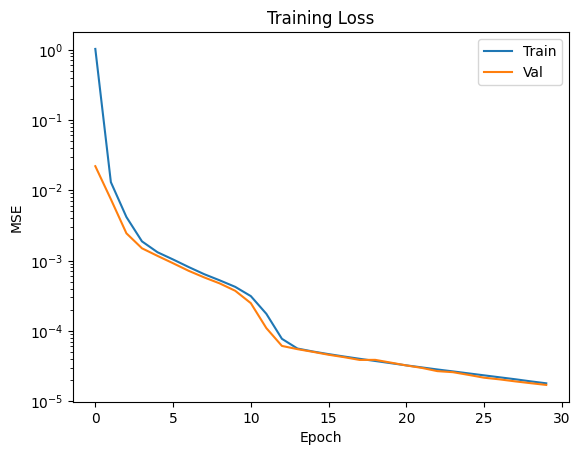

Test loss: 1.7155245586764067e-05


In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.yscale('log')
plt.title('Training Results')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Test loss
test_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f'Test loss: {test_loss}')


* If your loss hasn't converged (curve hasn't plateaued), try increasing the number of epochs.
* If the loss wildly oscillates, the learning rate might be too high and the model is jumping out of the minima.



## Visualize Latent Space

Since we have seen that the model generalizes well, we can trust that the model has learned an informative embedding of the multiband photometry. We now will analyze this two-dimensional latent space. We should expect that gradients in this space will align with color index and apparent brightness.

**An important note**: Sometimes, the latent space appears elongated along one axis. This occurs because the model is free to "choose" any 2D encoding that preserves good reconstruction of the SEDs, and it might end up being a bar or a well-seperated surface because of this.



26037/26037 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step


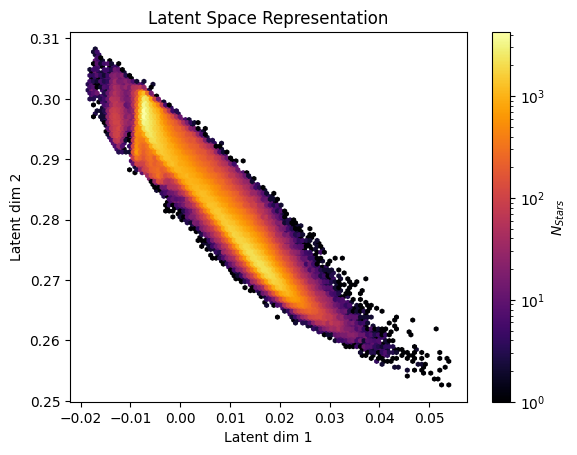

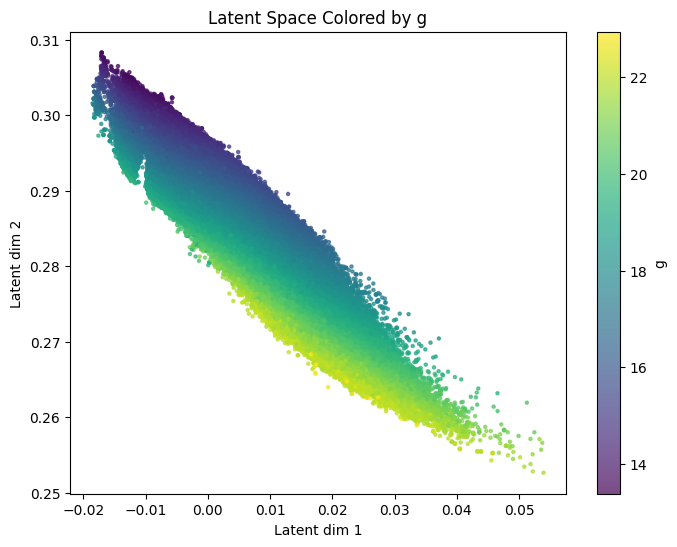

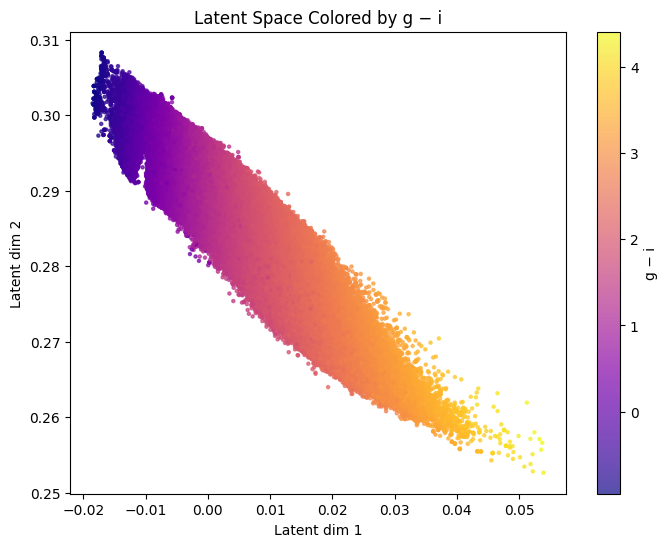

In [ ]:
encoder = Model(inputs, latent)
latent_space = encoder.predict(X)

Y_latent = Y.copy()
Y_latent['latent1'] = latent_space[:,0]
Y_latent['latent2'] = latent_space[:,1]

# Let us plot the latent space using hexbin, and color each hexagon bin by the number of stars in that bin.
plt.hexbin(latent_space[:, 0], latent_space[:, 1], gridsize=100, cmap='inferno', bins='log')
plt.colorbar(label=r'$N_{Stars}$')
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Latent Space Representation")
plt.show()

# Just the latent representation is not very useful, so lets color it by apparent magnitude in the g-band and g-i color.

df_phot_and_latent = pd.merge(df_combined, Y_latent, on='objID')

plt.figure(figsize=(8, 6))
sc = plt.scatter(df_phot_and_latent['latent1'], df_phot_and_latent['latent2'],
                 c=df_phot_and_latent['g'], cmap='viridis', s=5, alpha=0.7)
plt.colorbar(sc, label='g')
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Latent Space Colored by g")
plt.show()

df_phot_and_latent['g_minus_i'] = df_phot_and_latent['g'] - df_phot_and_latent['i']

plt.figure(figsize=(8, 6))
sc = plt.scatter(df_phot_and_latent['latent1'], df_phot_and_latent['latent2'],
                 c=df_phot_and_latent['g_minus_i'], cmap='plasma', s=5, alpha=0.7)
plt.colorbar(sc, label='g − i')
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Latent Space Colored by g − i")
plt.show()



Now its time for a post-label analysis! Let us use our object-types obtained from SIMBAD to see how different stellar populations "fill" the latent space.
We will plot various stellar types, described here:



*   RGB* (Red Giant Branch Stars): Evolved, more-luminous, and red.
*   HorBranch* (Horizontal Branch Stars): Helium-burning stars in a stable phase,luminous, temperature varies.
* Low-Mass*: Long-lived, red, and low-luminosity stars.
* Blue Straggler: Blue and hot stars, luminous, typically found in globular clusters, likely formed through mass transfer or stellar mergers.
* WhiteDwarf: very blue and hot stars, low-luminosity, have exhausted their nuclear fuel. The Sun's eventual fate.
* RRLyrae: Pulsating variable stars, luminous,  commonly found in globluar clusters.
* BrownD*_Candidate (Brown Dwarf Stars): low-luminosity, extremely red and cool, lack the mass to sustain nuclear fusion of hydrogen to helium.



Available SIMBAD object types:
['Star' 'RGB*' 'Variable*' 'HighPM*' 'ChemPec*' 'HorBranch*' 'Low-Mass*'
 'HorBranch*_Candidate' 'EclBin_Candidate' 'EclBin' 'PulsV*'
 'BlueStraggler' 'RSCVnV*' 'WhiteDwarf' 'RRLyrae' 'BrownD*_Candidate'
 'delSctV*' 'HotSubdwarf' 'YSO_Candidate' 'HighVel*' 'SB*'
 'HotSubdwarf_Candidate' 'C*' '**' 'LongPeriodV*' 'BYDraV*'
 'WhiteDwarf_Candidate' 'EmLine*' 'LongPeriodV*_Candidate' 'Eruptive*'
 'AGB*' 'Cepheid' 'CataclyV*' 'C*_Candidate' 'alf2CVnV*' 'Type2Cep'
 'EllipVar' 'GlobCluster' 'RGB*_Candidate' 'MainSequence*'
 'GlobCluster_Candidate' 'SXPheV*' 'post-AGB*' 'RRLyrae_Candidate' 'RotV*']


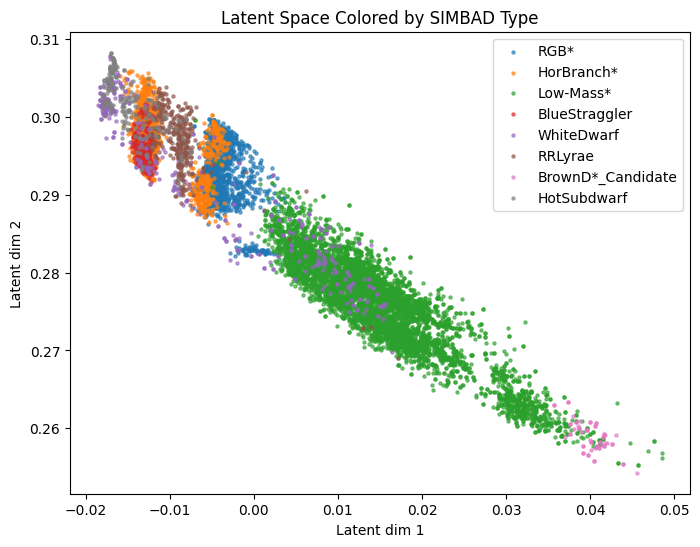

In [ ]:
df_simbad_latent = pd.merge(df_simbad, Y_latent, on='objID')

# Show all object types available in the DataFrame
unique_types = df_simbad_latent['object_type'].unique()
print("Available SIMBAD object types:")
print(unique_types)

# Plot selected types
plt.figure(figsize=(8, 6))
types_to_plot = [ 'RGB*', 'HorBranch*', 'Low-Mass*',
 'BlueStraggler',  'WhiteDwarf', 'RRLyrae', 'BrownD*_Candidate',
'HotSubdwarf']  # modify as needed based on what's printed

for obj_type in types_to_plot:
    subset = df_simbad_latent[df_simbad_latent['object_type'] == obj_type]
    plt.scatter(subset['latent1'], subset['latent2'], label=obj_type, alpha=0.6, s=5)

plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Latent Space Colored by SIMBAD Type")
plt.legend()
plt.show()


## HR Diagram & Anomaly Detection

Now that we've analyzed the latent space, let us now obtain predicted magnitudes for the five Pan-STARRS bands.

In [ ]:
# Run the full dataset through the trained model.
econstructed = autoencoder.predict(X)  # shape: (n_samples, 1, 5)
reconstructed = reconstructed.reshape(-1, 5)     # remove LSTM time dimension
reconstructed_unscaled = reconstructed * 10  # reverse scaling
recon_df = pd.DataFrame(reconstructed_unscaled, columns=['g_pred', 'r_pred', 'i_pred', 'z_pred', 'y_pred'])

Y_latent = Y_latent.reset_index(drop=True)
recon_df = recon_df.reset_index(drop=True)

df_latent_full = pd.concat([Y_latent, recon_df], axis=1)




26037/26037 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step


Since we have distance, we can use the distance modulus to compute *absolute magnitude* for a majority of our dataset. We will compute absolute magnitude using both the observed PS magnitude in the g-band and the LSTM-AE predicted magnitude in the g-band, allowing us to compute an \"AI Generated\" HR Diagram.

The Hertzsprung–Russell (HR) diagram is one of the most important tools in stellar astrophysics, as it reveals a star’s evolutionary stage based on its temperature and luminosity. We will be looking at the observational HR diagram, which plots absolute magnitude (directly related to luminosity) against the color (a proxy of temperature) of stars. *Hot stars will be on the left and cool stars on the right, and bright stars will be on the top and dim stars on the bottom.*

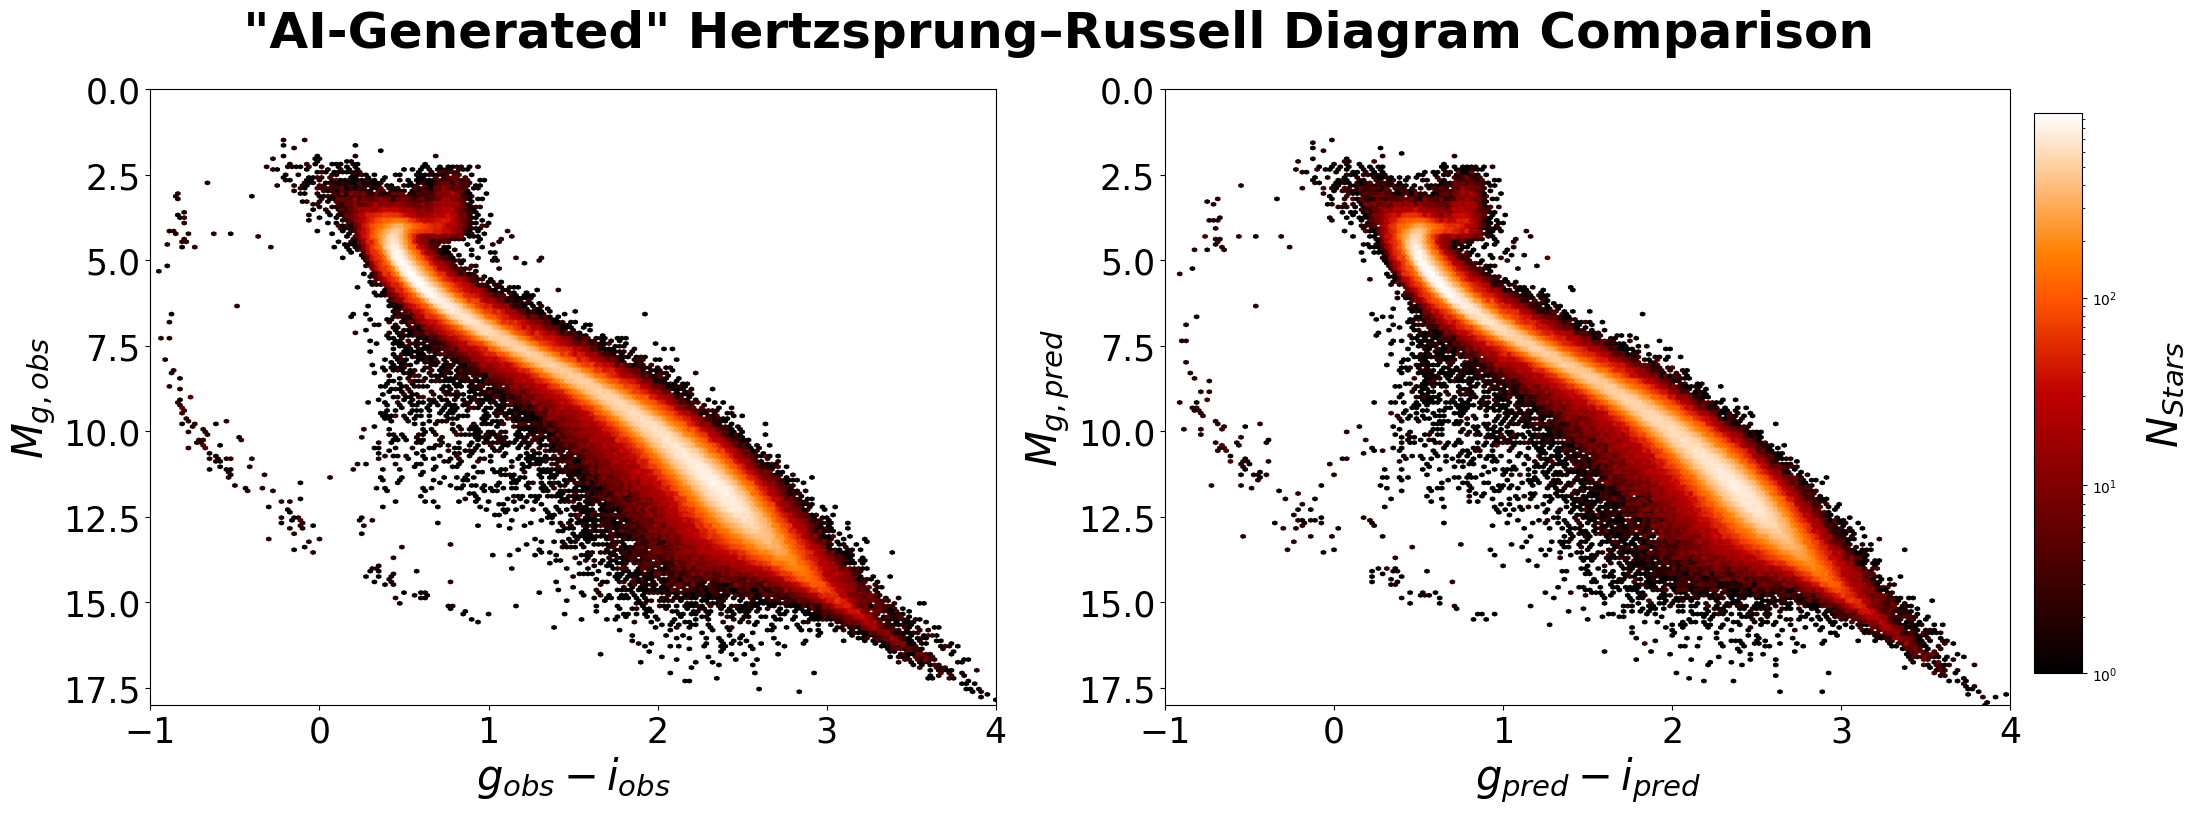

In [ ]:
df_gaia_latent = pd.merge(df_gaia, df_latent_full, on='objID')

df_gaia_latent = df_gaia_latent[df_gaia_latent['distance'] > 0]


df_gaia_latent['G_obs'] = df_gaia_latent['g'] - 5*np.log10(df_gaia_latent['distance']/10*1000)
df_gaia_latent['G_pred'] = df_gaia_latent['g_pred'] - 5*np.log10(df_gaia_latent['distance']/10*1000)


# Creation of the plots ---------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Compute counts for logarithmic scaling
counts1, _, _ = np.histogram2d(df_gaia_latent['g'] - df_gaia_latent['i'], df_gaia_latent['G_obs'], bins=100)
counts2, _, _ = np.histogram2d(df_gaia_latent['g_pred'] - df_gaia_latent['i_pred'], df_gaia_latent['G_pred'], bins=100)

# Replace non-positive counts with NaN to avoid errors when taking log
counts1[counts1 <= 0] = np.nan
counts2[counts2 <= 0] = np.nan

# Define global vmin and vmax for log scale
vmin = np.nanmin([counts1, counts2])
vmax = np.nanmax([counts1, counts2])

# Left subplot (original)
im1 = ax1.hexbin(df_gaia_latent['g'] - df_gaia_latent['i'], df_gaia_latent['G_obs'],
                  gridsize=200, cmap='gist_heat',
                  extent=(-1, 4, 0, 18),
                  bins='log')
ax1.set_xlim(-1, 4)
ax1.set_ylim(0, 18)
ax1.invert_yaxis()
ax1.set_xlabel('$g_{obs}-i_{obs}$', fontsize=30)
ax1.set_ylabel('$M_{g, obs}$', fontsize=30)

ax1.tick_params(axis='both', which='major', labelsize=25)


# Right subplot (pred - neural network prediction)
im2 = ax2.hexbin(df_gaia_latent['g_pred'] - df_gaia_latent['i_pred'], df_gaia_latent['G_pred'],
                  gridsize=200, cmap='gist_heat',
                  extent=(-1, 4, 0, 18),
                  bins='log')
ax2.set_xlim(-1, 4)
ax2.set_ylim(0, 18)
ax2.invert_yaxis()

ax2.set_xlabel('$g_{pred} - i_{pred}$', fontsize=30)
ax2.set_ylabel('$M_{g, pred}$',fontsize=30)

ax2.tick_params(axis='both', which='major', labelsize=25)


# Adjust layout to make room for the colorbar
plt.subplots_adjust(right=0.9)  # Leave space for the colorbar
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Position the colorbar to the right
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(r'$N_{Stars}$', rotation=90, labelpad=20, fontsize=30)

fig.suptitle(" \"AI-Generated\" Hertzsprung–Russell Diagram Comparison", fontsize=36, weight='bold')

plt.show()


Lastly, we will do anomaly detection! We will compute the MSE for each star, which was the loss-function for our model, and classify anomalous stars as stars that are in the top 1% of reconstruction error. Then, we will look at detected anomalies in color-color plots, and see that anomalies correspond to certain, underpopulated regions in color-color space. Color-color space is a way to visualize stars by comparing their differences in apparent brightness (magnitudes) between filters, aiding in the determination of temperature, metallicity, and stellar type.

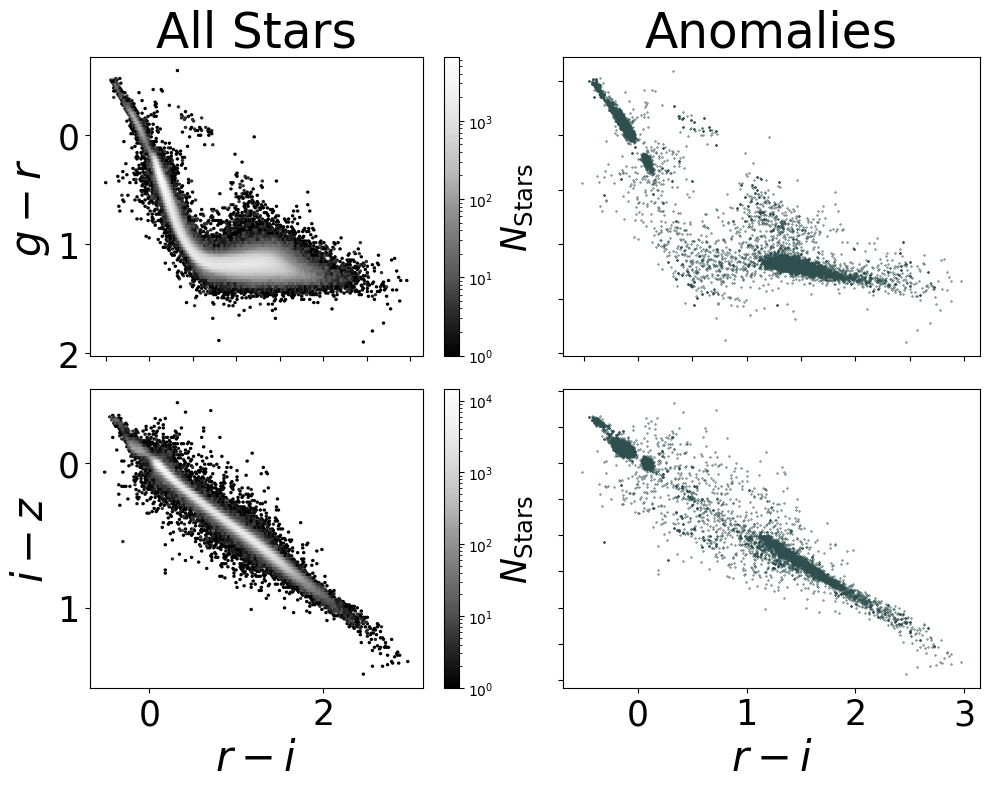

In [ ]:
from sklearn.metrics import mean_squared_error

# Compute per-star MSE across grizy,
mse = np.mean((df_combined[bands].values - df_latent_full[['g_pred','r_pred','i_pred','z_pred','y_pred']].values)**2, axis=1)
df_latent_full['recon_error'] = mse

# Define anomalies as top 1% in reconstruction error
threshold = np.percentile(df_latent_full['recon_error'], 99)
df_anomalies = df_latent_full[df_latent_full['recon_error'] > threshold]
df_anomalies_all = pd.merge(df_anomalies, df_combined, on='objID')

df_all = pd.merge(df_combined, df_latent_full, on='objID')


# Plots --------------------------------

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Panel 1: All stars (g−r vs r−i)
ax1 = axes[0, 0]
hb1 = ax1.hexbin(
    df_all['r'] - df_all['i'],
    df_all['g'] - df_all['r'],
    gridsize=150,
    cmap='Greys_r',
    bins='log'
)
cb1 = fig.colorbar(hb1, ax=ax1)
cb1.set_label(r'$N_{\mathrm{Stars}}$', fontsize=25)
ax1.set_title('All Stars', fontsize=35)
ax1.set_ylabel('$g - r$', fontsize=30)
ax1.invert_yaxis()

# Panel 2: Anomalies (g−r vs r−i) — scatter
ax2 = axes[0, 1]
ax2.scatter(
    df_anomalies_all['r'] - df_anomalies_all['i'],
    df_anomalies_all['g'] - df_anomalies_all['r'],
    marker='x',
    c='darkslategrey',
    s=1,
    alpha=0.5,
    label='Anomalies'
)
ax2.set_title('Anomalies', fontsize=35)
ax2.invert_yaxis()

# Panel 3: All stars (i−z vs r−i)
ax3 = axes[1, 0]
hb3 = ax3.hexbin(
    df_all['r'] - df_all['i'],
    df_all['i'] - df_all['z'],
    gridsize=150,
    cmap='Greys_r',
    bins='log'
)
cb3 = fig.colorbar(hb3, ax=ax3)
cb3.set_label(r'$N_{\mathrm{Stars}}$', fontsize=25)
ax3.set_xlabel('$r - i$', fontsize=30)
ax3.set_ylabel('$i - z$', fontsize=30)
ax3.invert_yaxis()

# Panel 4: Anomalies (i−z vs r−i) — scatter
ax4 = axes[1, 1]
ax4.scatter(
    df_anomalies_all['r'] - df_anomalies_all['i'],
    df_anomalies_all['i'] - df_anomalies_all['z'],
    marker='x',
    c='darkslategrey',
    s=1,
    alpha=0.5,
    label='Anomalies'
)
ax4.set_xlabel('$r - i$', fontsize=30)
ax4.invert_yaxis()

# Format ticks
axes = axes.flatten()
for i, ax in enumerate(axes):
    row, col = divmod(i, 2)
    if row == 1:
        ax.tick_params(axis='x', labelsize=25)
    else:
        ax.set_xticklabels([])

    if col == 0:
        ax.tick_params(axis='y', labelsize=25)
    else:
        ax.set_yticklabels([])

# Tight layout & show
plt.tight_layout()
plt.show()



That is it for this tutorial! I hope you enjoyed seeing and getting hands-on experience with an application of machine learning in astronomy!